In [181]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from DSH import MIfile as MI
from DSH import Config as cf
from DSH import ROIproc as RP
from DSH import SharedFunctions as sf
from DSH import IOfunctions as iof

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('ROI processing tutorial started')

INFO:root:ROI processing tutorial started


# Processing Regions Of Interest (ROIs)

```CorrMaps``` class is designed to compute correlations with maximum spatial resolution. This comes at the expense of computation time and of output size. When maximum spatial resolution is not the priority, it may be convenient to average the intensity correlation on fewer, extended Regions Of Interest (ROIs). This is done by the ```ROIproc``` class. We test it on a dummy dataset:

DEBUG:root:MIfile object created with filename D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.01_SS\000_PIV_0p010_CAM0.raw
DEBUG:root:Now loading MIfile metadata (from filename: D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.01_SS\000_PIV_0p010_CAM0_metadata.ini)
DEBUG:root:Loading config file D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.01_SS\000_PIV_0p010_CAM0_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


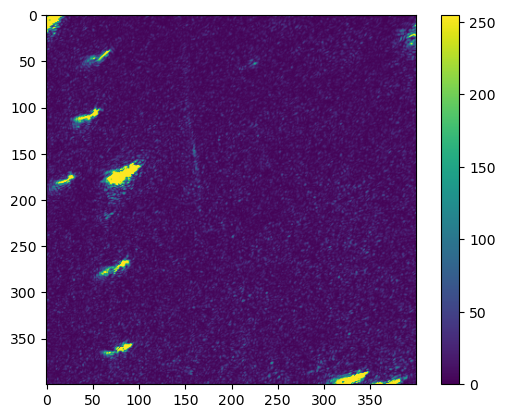

In [61]:
froot = r'D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.01_SS'
fname = '000_PIV_0p010'
MIinput = MI.MIfile(os.path.join(froot, fname+'_CAM0.raw'), os.path.join(froot, fname+'_CAM0_metadata.ini'))
MIinput.OpenForReading()
im1 = MIinput.GetImage(0)
plt.imshow(im1)
plt.colorbar()

### Defining a set of ROIs

To define a set of ROIs, the fist thing required is a reference system. Both cartesian and polar coordinates are supported, and can be generated, for a given image shape, by calling:

```python
grid = SharedFunctions.PixelCoordGrid(shape, extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
```

where:
- ```shape``` is the shape of the map, in number of pixels ```[num_rows, num_cols]```
- ```extent``` is the cartesian extent of the mapping, in physical units ```[x_left, x_right, y_bottom, y_top]```. They can eventually be reversed (e.g. ```x_right<x_left```). If it is set to ```None```, it takes the default value ```[0, shape[1], shape[0], 0]```
- ```center``` is the origin of the coordinate system, in physical units
- ```angle``` is a parameter eventually rotating the coordinate system by a given angle, in radians. For cartesian coordinates, ```angle=0``` means $(x', y')=(x, y)$, whereas ```angle=pi/2``` means $(x', y')=(y, -x)$. For polar coordinates, ```angle=0``` means $\theta=0$ along $+x$, whereas ```angle=pi/2``` means $\theta=0$ along $+y$ (note: this means downwards if ```indexing='xy'```)
- ```coords``` is the choice of the coordinate system: set it to ```['cartesian'|'polar']``` to return ```[x,y]``` or ```[r,theta]``` respectively
- ```indexing``` is the choice of ```numpy.meshgrid``` indexing method. Set it to ```['xy'|'ij']``` to return cartesian coordinates or rows and columns 

Based on this set of coordinates, ROIs can be defined by their center coordinates and their extent: $(x, y, dx, dy)$ or $(r, \theta, dr, d\theta)$. The resulting set of ROIs is stored as a list of binary masks one for each ROI.

```python
ROI_masks = RP.GenerateMasks(coords, grid, common_mask=None)
```

where:
- ```coords``` is a list of mask coordinates in the form ```[x0, x1, dx0, dx1]```
- ```grid``` is a grid of coordinates, as generated by ```RP.PixelCoordGrid```
- ```common_mask``` eventually contains a common mask with pixels to be excluded from all ROIs



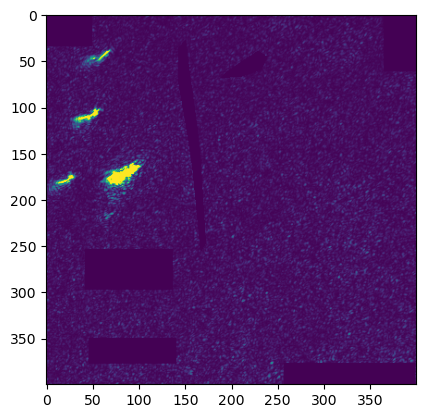

In [6]:
pxmask = MI.ReadBinary(os.path.join(froot, 'px_mask_CAM0.raw'), MIinput.ImageShape(), 'B')
plt.imshow(pxmask)

The entire image can be tiled with ROIs using:

```python
ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, GridShape, coord_limits=None, common_mask=None)
```

where:
- ```px_coords``` is a grid of pixel coordinates, as generated by ```RP.PixelCoordGrid```
- ```GridShape``` is a couple ```(M,N)``` specifying the number of ROIs across each coordinate axis
- ```coord_limits``` eventually restricts the tiling to a subset of the entire space defined by its boundaries along each axis: ```[[min_x0, max_x0], [min_x1, max_x1]]```. If None, full axis span will be taken

DEBUG:root:16 binary masks created with shape (400, 400)


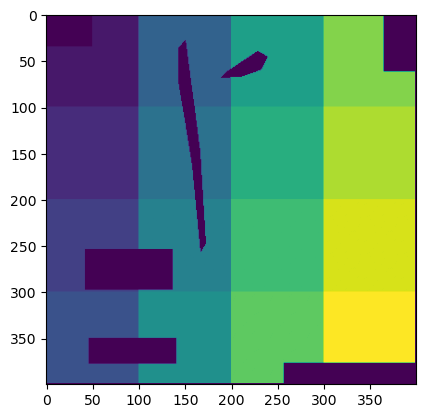

In [12]:
ROI_gridshape = (4, 4)
px_coords = sf.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, ROI_gridshape, common_mask=pxmask)
plt.imshow(RP.BinaryToIntegerMask(ROI_grid))

### The ROIproc class

The ```ROIproc``` class does this analysis on an input ```MIfile```. To initialize a ```ROIproc``` object:

```python
ROI_proc = RP.ROIproc(MIin, ROImasks, ROImetadata=None, imgTimes=None, expTimes=[1])
```

where:
- ```MIin``` is the input ```MIfile``` or ```MIstack``` to be processed.
- ```ROImasks``` is the list of binary masks Each mask is a 2D binary array with same shape as ```MIin.ImageShape()```. ```True``` values (nonzero) denote pixels that will be included in the analysis, ```False``` values (zeroes) will be excluded. If ```None```, all pixels will be included.
- ```ROImetadata``` eventually specifies a ```dict``` of ROI metadata.  Can contain one or more of the following keys:
    - ```'coords'``` : ndarray with ROI coordinates. If not set, ```ROIcoords=np.arange(self.CountROIs())```
    - ```'coord_names'``` : list of ```str```: coordinate names. If not set, ```ROIcoord_names = [coord0, coord1, ...]```
    - ```'box_margin'``` : positive ```int``` with margin left for drift measurement. Default: 0
- ```imgTimes``` is a ```float``` array of length ```MIin.ImageNumber()```. i-th element will be the time of the image in physical units. If ```None```, time will be measured in image units.

**NOTE: Image times and exposure times**

In typical experiments, images are acquired at a constant rate (FPS), specified in the metadata of each MIfile (see tutorial 1). However, there are cases in which custom acquisition schemes may be used to enhance the sensitivity to both the fastest and the slowest dynamics. In these cases, the time at which each image has beed taken (```imgTimes```) needs to be provided. It is usually saved in an ASCII file accompanying the raw file with the images. If this is the case, image times can be extracted using:

```python
im_times = RP.LoadImageTimes(img_times_source, usecols=0, skiprows=1, root_folder=None, return_unique=False)
```

where:
- ```img_times_source``` is the file name or list of filenames. If several filenames are given, results will be concatenated 
- ```usecols``` is index of the column in the file containing image times
- ```skiprows``` is the number of rows to be skipped at the beginning of the file
- ```root_folder``` is the root folder path. If specified, img_times_source will be interpreted as a relative path
- ```return_unique``` : if ```True```, remove duplicates before returning result

In addition, because sometimes the dynamic range of a typical 8bit camera is not enough to properly measure speckle patterns with spatially-modulated intensities, where the intensity may vary of several orders of magnitude, the same speckle field is typically recorded using multiple exposure times.
Combining images taken at different exposure time in one unique spectrum requires knowledge of the exposure times (```expTimes```).

In [64]:
im_times = RP.LoadImageTimes(fname+'_imgTimes.dat', usecols=5, skiprows=1, root_folder=froot)
im_times

array([[0.00000e+00],
       [9.88320e-03],
       [1.98783e-02],
       ...,
       [9.99699e+01],
       [9.99799e+01],
       [9.99899e+01]])

In [13]:
ROI_proc = RP.ROIproc(MIinput, ROI_grid, imgTimes=im_times)
ROI_proc

INFO:root:Set 16 valid ROIs
DEBUG:root:10000 image times automatically generated from MI metadata (fps=1.0Hz)
DEBUG:root:Set one single exposure time: 1


<ROIproc object: MIfile (D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.01_SS\000_PIV_0p010_CAM0.raw) + 16 ROIs>

In [11]:
print(ROI_proc)


|-----------------|
|  ROIproc class: |
|-----------------+---------------
| Input           : MIfile (..\ROI_test\MI.raw), 10 images
| ROIs            : 4 (4 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
|-----------------+---------------


In [14]:
ROI_proc.imgTimes

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.997e+03, 9.998e+03,
       9.999e+03])

The binary masks for the ROIs are stored in ```ROIproc.ROI_masks``` (or in its integer map form ```ROIproc.ROIs```):

```ROIproc``` stores also the area of each ROI, to speed up normalization of ```RP.ROIAverage```. It is saved in ```ROIproc.ROI_maskSizes```:

In [15]:
ROI_proc.ROI_maskSizes

array([ 8228, 10000,  7448,  8388,  9079,  8902,  7959,  8752,  9344,
       10000, 10000,  8954,  7836,  9900,  9900,  7623])

### Complete analysis

This multi-step analysis can be run through the function:
```python
ROIproc.doDLS(saveFolder, lagtimes, reftimes='all', drift_corr=0, no_buffer=False, force_SLS=True, save_transposed=False, include_negative_lags=False)
```

where:

- ```saveFolder```: folder path to export analysis output
- ```lagtimes```: ```'all'``` or list of ```int```.
    - If ```'all'```, all available lagtimes will be processed
    - Otherwise, only specified lagtimes will be processed
- ```reftimes```: ```'all'``` or list of ```int```.
    - If ```'all'```, all reference times will be used
    - Otherwise, specialize the analysis to a subset of reference times specified in the list
- ```drift_corr```: positive integer to compute drift-corrected correlations (see below)
- ```no_buffer```: If ```True```, avoid reading full MIfile to RAM. It saves memory but slows down processing.
- ```force_SLS```: If ```False```, program will load previously computed SLS results if available.
- ```save_transposed```: specifies the format of correlation timetrace output
    - if ```False```, classic cI output: one line per reference time, one column per time delay
    - if ```True```, transposed output: one line per time delay, one column per reference time
- ```include_negative_lags```: eventually include negative lagtime in the analysis
    - if ```False``` (default), only process prositive lagtimes. If ```reftimes=='all'```, negative lagtimes are redundant and ```include_negative_lags``` will be set to ```False```. 
    - If sparse ```reftimes``` are processed, set ```include_negative_lags==True``` to include negative lagtimes

In [28]:
fout = os.path.join(froot, 'out_CAM0')
ROI_proc.doDLS(fout, lagtimes=list(range(1,200)), reftimes='all', no_buffer=False)

INFO:root:ROIproc.doDLS Analysis started! Input data is 10000 images (10000 times, 1 exposure times)
INFO:root:Analysis will resolve 16 ROIs and DLS will be performed on 10000 reference times and 200 lagtimes. Output will be saved in folder D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.01_SS\out_CAM0
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (10000, 1, 16)), Iavg data (shape: (10000, 16)), exptime data (shape: (10000, 16)), buffer images (shape (10000, 399, 399))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 10000 time points, 200 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 10000, 1] (10000 images)
INFO:root:Computing cI with custom-defined set of reference time and/or lag times: result has shape (16, 10000, 200) (16 ROIs, 10000 reference times, 200 lag times)
DEBUG:root:Number of reference times (10000) exceeding 100: logging every 1

The final step of the analysis computes the time-averaged correlation functions $g_2(\tau)-1$ from two-point correlations $c_I(t, \tau)$. This can be done after the analysis using:

```python
ROI_proc.AverageG2M1(folder_path, avg_interval=None, search_prefix=['cI_','cIcr_','dx_','dy_'], save_prefix=['g2m1','g2m1cr','avgdx','avgdy'], save_stderr=False, sharp_bound=False, lag_tolerance=1e-2, lag_tolerance_isrelative=True)
```

where:

- ```folder_path```: folder path containing cI-like output files to be loaded and time-averaged. Output data is also saved in ```folder_path```.
- ```avg_interval```:  ```None```, ```int```, single interval ```[min_idx, max_idx, [step_idx=1]]``` or list of intervals ```[interval1, ..., intervalN]```, as in the ```ROIproc.AverageCorrTimetrace``` function described above.
- ```search_prefix``` and ```save_prefix```: lists of ```str```. Number of elements in ```save_prefix``` must match that of ```search_prefix```. For each file with a given ```search_prefix```, the output g2m1 file will have the corresponding ```save_prefix```.
- ```save_stderr```: ```bool```. If ```save_stderr==False```, the output file will have ```2N``` columns, one per reference time. Columns will be: ```[tau_1, g2m1_1, tau_2, g2m1_2, ..., tau_N, g2m1_N]```. Otherwise, the function will also calculate the standard deviation of the correlation values being averaged, and save it into an additional column. In this case, columns in the output file will be: ```[tau_1, g2m1_1, g2m1err_1, tau_2, g2m1_2, g2m1err_2, ..., tau_N, g2m1_N, g2m1err_N]```.
- ```sharp_bound```: ```bool```. If you want ```avg_interval``` to restrict not only the reference time $t$, but also the later time $t+\tau$, set ```sharp_bound=True```. 
- ```lag_tolerance```, ```lag_tolerance_isrelative```. Parameters specifying the criterion to group *equal* time delays together (see ```ROIproc.AverageCorrTimetrace``` above for details)

This function loads all cI-like output files from the specified ```folder_path``` (cI-like is defined by the ```.dat``` extension and a prefix included in the list of prefixes specified in ```search_prefix```), average correlation data with the same timelag and save them to g2-1 files, replacing the prefix with the corresponding one specified in ```save_prefix```.

In [32]:
ROI_proc.AverageG2M1(fout, avg_interval=[2,6], sharp_bound=True)

C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\ROIproc.py:488: RuntimeWarning: invalid value encountered in true_divide
  g2m1 = np.divide(g2m1, g2m1_avgnum)
C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\ROIproc.py:501: RuntimeWarning: invalid value encountered in true_divide
  g2m1_err = np.sqrt(np.divide(g2m1_err, g2m1_avgnum))


### Visualizing output

Analysis result is saved in the specified output folder. 
Several output files will be generated:

- **analysis_log.txt**: log file keeping track of analysis steps performed and time taken to perform each step
- ROIproc configuration
    - **ROIcoords.dat**: ROI coordinates, if given, and normalization factors (ROI areas)
    - **ROImask.raw**: raw image (data type: 32bit integer, signed, no header, same shape as original image). Pixel value is the index of the ROI that pixel belongs to (0-based, as in the DLS filenames), and -1 for pixel not belonging to any ROI
    - **ROIprocConfig.ini**: configuration file containing analysis and ```ROIproc``` parameters
    - **imgTimes.dat**: list of image times
- SLS output:
    - **Iavg_raw.dat**: ROI-averaged image intensity for each input image (one per exposure time, if multiple exposure times are present). Ageraged intensity is already normalized by the exposure time
    - **exptimes.dat**: optimal exposure time for each ROI and acquired image
    - **Iavg.dat**: ROI-averaged optimal image intensity for each input image (obtained selecting the optimal exposure time reported in exptimes.dat)
- DLS output:
    - **cI_ROIxxx_eyy.dat**: correlation timetraces, where xxx is the ROI index and yy the exposure time index
    - **g2m1_ROIxxx_eyy.dat**: time-averaged correlation functions
- Drift-corrected DLS output:
    - **cIcr_ROIxxx_eyy.dat**: timetrace of the peak of spatial crosscorrelation
    - **g2m1cr_ROIxxx_eyy.dat**: time-averaged decay of crosscorrelation peak
    - **dx_ROIxxx_eyy.dat**, **dy_ROIxxx_eyy.dat** x and y components of the correlation peak drift
    - **avgdx_ROIxxx_eyy.dat**, **avgdy_ROIxxx_eyy.dat** time-averaged x and y components of the correlation peak drift

In [19]:
for i in os.listdir(fout):
    print(i)

analysis_log.txt
cI_ROI000_e00.dat
cI_ROI001_e00.dat
cI_ROI002_e00.dat
cI_ROI003_e00.dat
cI_ROI004_e00.dat
cI_ROI005_e00.dat
cI_ROI006_e00.dat
cI_ROI007_e00.dat
cI_ROI008_e00.dat
cI_ROI009_e00.dat
cI_ROI010_e00.dat
cI_ROI011_e00.dat
cI_ROI012_e00.dat
cI_ROI013_e00.dat
cI_ROI014_e00.dat
cI_ROI015_e00.dat
exptimes.dat
g2m1_ROI000_e00.dat
g2m1_ROI001_e00.dat
g2m1_ROI002_e00.dat
g2m1_ROI003_e00.dat
g2m1_ROI004_e00.dat
g2m1_ROI005_e00.dat
g2m1_ROI006_e00.dat
g2m1_ROI007_e00.dat
g2m1_ROI008_e00.dat
g2m1_ROI009_e00.dat
g2m1_ROI010_e00.dat
g2m1_ROI011_e00.dat
g2m1_ROI012_e00.dat
g2m1_ROI013_e00.dat
g2m1_ROI014_e00.dat
g2m1_ROI015_e00.dat
Iavg.dat
Iavg_raw.dat
imgTimes.dat
ROIcoords.dat
ROIprocConfig.ini
ROI_mask.raw


A few functions in ```IOfunctions``` make it easier to read these output files:

```python
# To open a generic ASCII file with results:
res_arr[, hdr_list][, firstcol] = IOfunctions.LoadResFile(fname, readHeader=True, isolateFirst=0, delimiter=',', comments='#')
```

The function returns:
- ```res_arr```: a 1D or 2D array with data in the input file
- ```hdr_list```: a list of header entries ```(str)```, as many as the number of columns in ```res_arr``` (independently of ```isolateFirst```). Header is the first line of the ASCII file. Only returned if ```readHeader==True```
- ```firstcol```: a 1D or 2D array with the first ```isolateFirst``` initial columns, isolated from the rest of the data. Only returned if ```isolateFirst>0```

```python
# To open Iavg_raw.dat
Iav, roi_coords, times, exptimes = IOfunctions.OpenRawSLS(fname, roi_numcoords=2, delimiter='\t', comments='#')
```

The function returns:
- ```Iav```: a 2D or 3D array with ROI-averaged intensities. ```Iav[i,j,k]``` is the average on ```i```-th ROI of the image taken at ```j```-th time with ```k```-th exposure time. If only one time or one exposure time are present, the result is squeezed to a 2D array
- ```roi_coords```: a 1D or 2D array, depending on ```roi_numcoords```, with the ROI coordinates
- ```times```: 1D or 2D array array with image times for each SLS spectrum ```Iav[:,j,k]``` or ```Iav[:,j]```, in physical units (default: seconds)
- ```exptimes```: 1D or 2D array array with exposure times for each SLS spectrum, in physical units (default: milliseconds)

```python
# To open Iavg.dat
Iav, roi_coords, times = IOfunctions.OpenSLS(fname, roi_numcoords=2, delimiter='\t', comments='#')
```

The function returns:
- ```Iav```: a 2D array with ROI-averaged intensities. ```Iav[i,j]``` is the average on ```i```-th ROI of the image taken at ```j```-th time with the best exposure time.
- ```roi_coords```: a 1D or 2D array, depending on ```roi_numcoords```, with the ROI coordinates
- ```times```: 1D array array with image times for each SLS spectrum ```Iav[:,j]```, in physical units (default: seconds)

```python
# To open cI_ROIxxx_eyy.dat
cI_data, times, lagidx_list = IOfunctions.ReadCIfile(fpath, time_colidx=1, delimiter='\t', comments='#')
```

The function returns:
- ```cI_data```: a 2D array with two-time correlation values. ```cI_data[i,j]``` is the correlation between image taken at ```i```-th time (as specified in the ```reftimes``` parameter of ```ROI_proc.doDLS```) with the image taken at a time set by the ```j```-th lagtime (as specified in the ```lagtimes``` parameter of ```ROI_proc.doDLS```).
- ```times```: 1D array array with times of each reference image, in physical units (default: seconds)
- ```lagidx_list```: 1D array with lagtimes in image units ```(int)```

cI_data.shape = (1000, 30)
times         = [   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000. 1010. 1020. 1030. 1040. 1050. 1060. 1070.
 1080. 1090. 1100. 1110. 1120. 1130. 1140. 1150. 1160. 1170. 1180. 1190.
 1200. 1210. 1220. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300. 1310.
 1320. 1330. 1340. 1350. 1360. 1370. 1380. 1390. 1400. 1410. 1420. 1430.
 1440. 1450. 1460. 1470. 1480. 1490. 1500. 1510. 1520. 1530. 1540. 1550.
 1560. 1

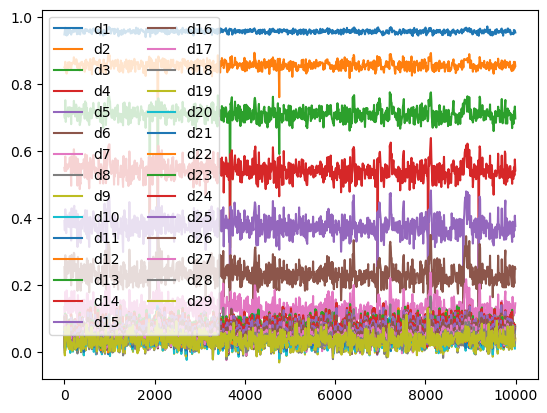

In [23]:
cI_data, times, lagidx_list = iof.ReadCIfile(os.path.join(fout, 'cI_ROI009_e00.dat'))
print('cI_data.shape = ' + str(cI_data.shape))
print('times         = ' + str(times))
print('lagidx_list   = ' + str(lagidx_list))
for i in range(1,len(lagidx_list)):
    plt.plot(times, cI_data[:,i], label='d'+str(lagidx_list[i]))
plt.legend(ncol=2)

```python
# To open all cI_*.dat files in folder
cI_data, times, lagidx_list, ROI_list, exptime_list = IOfunctions.OpenCIs(froot, fname_prefix='cI_', time_colidx=1, delimiter='\t', comments='#')
```

The function returns:
- ```cI_data```: list of 2D arrays, each one as returned by ```IOfunctions.ReadCIfile```
- ```times```, ```lagidx_list```: lists of 1D arrays with times and lagtimes, one element per ROI (they should be all equal)
- ```ROI_list```, ```exptime_list```: list of ROI and exptime indices

In [39]:
cI_data, times, lagidx_list, ROI_list, exptime_list = iof.OpenCIs(fout)
print('cI_data: {0} elements, each of shape {1}'.format(len(cI_data), cI_data[0].shape))
print('times: {0} elements, first element: {1}'.format(len(times), times[0]))
print('lagidx_list: {0} elements, first element: {1}'.format(len(lagidx_list), lagidx_list[0]))
print('ROI_list ({0} elements): {1}'.format(len(ROI_list), ROI_list))
print('exptime_list ({0} elements): {1}'.format(len(exptime_list), exptime_list))

cI_data: 4 elements, each of shape (10, 10)
times: 4 elements, first element: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
lagidx_list: 4 elements, first element: [0 1 2 3 4 5 6 7 8 9]
ROI_list (4 elements): [0, 1, 2, 3]
exptime_list (4 elements): [0, 0, 0, 0]


```python
# To open one or all g2m1_*.dat files in folder
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = IOfunctions.OpenG2M1s(froot, expt_idx=None, roi_idx=None, fname_prefix='g2m1_', time_colidx=1, delimiter='\t', comments='#')
```

If specified, ```expt_idx``` and/or ```roi_idx``` filter the selection to the given exposure time and ROI indexes

The function returns:
- ```g2m1_data```: list of 2D arrays, each one with correlation functions $g_2(\tau)-1$ for one given ROI. They can eventually be time-resolved: one column per time point. The first row ($\tau=0$) reports the contrast (```d0```) before normalization
- ```lagtimes```: lists of 2D arrays with lagtimes relative to ```g2m1_data``` points, in physical units (the same as times in cI data)
- ```imgtimes```: list of 1D arrays with timepoints relative to columns in ```g2m1_data```, in physical units
- ```ROI_list```, ```exptime_list```: list of ROI and exptime indices

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 4 g2-1 functions loaded from 4 ROIs found in folder ..\ROI_test\out


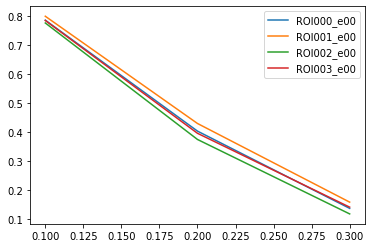

In [40]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout)
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

### Load config or analysis from file

```ROIproc.ExportConfiguration()```, called with ```doDLS```, saves all the configuration files needed to reinitialize ```ROIproc``` together with the whole analysis. 
The configuration file can be directly imported into a ```Config``` object:

In [42]:
out_config = cf.Config(os.path.join(fout, 'ROIprocConfig.ini'))
print(out_config)


|---------------|
| Config class: |
|---------------+---------------
| Section count : 7
| Total keys    : 38
| General       : <4 keys>
|                 version = 2.0
|                 generated_by = ROIproc.doDLS
|                 generated_on = 09/28/2024, 14:20:04
|                 folder = C:\Users\steaime\Documents\Codes\DSH\ROI_test\out
| MIfile        : <8 keys>
|                 hdr_len = 0
|                 px_format = B
|                 fps = 10
|                 px_size = 1
|                 shape = [10, 256, 256]
|                 comments = experiment result
|                 is_stack = False
|                 filename = C:\Users\steaime\Documents\Codes\DSH\ROI_test\MI.raw
| ROIs          : <5 keys>
|                 number = 4
|                 box = [40, 50, 250, 225]
|                 box_margin = 0
|                 coord_file = ROIcoords.dat
|                 mask_file = ROI_mask.raw
| ImgTimes      : <4 keys>
|                 number = 10
|                 file =

This configuration can be used to re-run the analysis with the same parameters, using the function

```python
ROI_proc.RunFromConfig(ConfigParams, AnalysisSection='Analysis', OutputSubfolder='reproc', export_configparams=None)
```

where:
- ```ConfigParams``` is the full path of the config file to read or a Config object containing the analysis parameters
- ```AnalysisSection``` is the name of the configuration section containing analysis parameters
- ```OutputSubfolder``` is the name of the subfolder to save the analysis output. Root folder would be the ```Analysis.out_folder``` field. Set it to ```None``` to save the output in ```Analysis.out_folder```
- ```export_configparams``` is a ```dict``` eventually containing additional parameters to export with the analysis configuration file

In [43]:
ROI_proc.RunFromConfig(out_config)

DEBUG:root:Config.LoadConfig() assuming that input is of Config type (7 sections)
INFO:root:ROIproc.RunFromConfig running DLS analysis
INFO:root:ROIproc.doDLS Analysis started! Input data is 10 images (10 times, 1 exposure times)
INFO:root:Analysis will resolve 4 ROIs and DLS will be performed on 10 reference times and 10 lagtimes. Output will be saved in folder C:\Users\steaime\Documents\Codes\DSH\ROI_test\out\reproc
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (10, 1, 4)), Iavg data (shape: (10, 4)), exptime data (shape: (10, 4)), buffer images (shape (10, 210, 175))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 10 time points, 10 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 10, 1] (10 images)
INFO:root:Contrast (d0) processed
DEBUG:root:Number of lagtimes (10) exceeding 3: logging every 4-th lagtime processed
INFO:root:Lagtime 4/9 (d4)

The configuration file can also be used to load a new ```ROIproc``` object and eventually re-run the analysis, using the function

```python
ROI_proc_reload = RP.LoadFromConfig(ConfigParams, runAnalysis=True)
```

where:
- ```ConfigParams``` is the full path of the config file to read or a dict or a Config object
- ```runAnalysis=True``` runs the analysis after initializing the object using ```ROI_proc.RunFromConfig```

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 16 g2-1 functions loaded from 16 ROIs found in folder D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.01_SS\out_CAM0


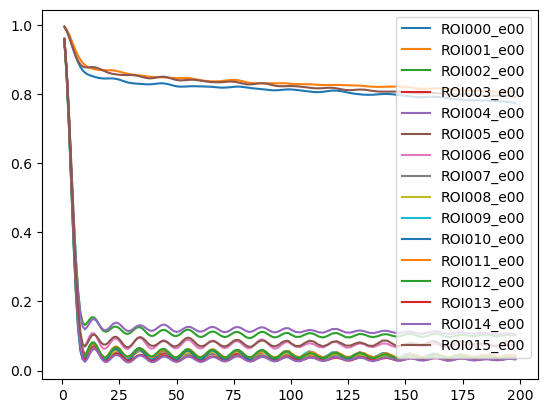

In [46]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout)
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()

In [58]:
z = 30 #cm
x = 6.5*2.5 #cm
theta = np.arctan2(x, z) #rad
wavelength = 0.532 #micron
k = 2*np.pi/wavelength #1/micron
q = 2*k*np.sin(theta/2) #1/micron
q

5.802983306027009

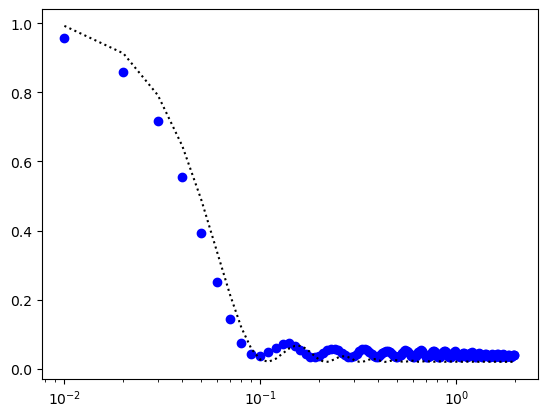

In [59]:
def sincsq(x):
    return np.square(np.sin(x)/x)

fps=100
test_tau_frames = np.linspace(1, 200, 200)
test_tau_s = test_tau_frames/fps
v_set = 10 #micron/s
expected_g2 = np.array([sincsq(v_set*t * q/2) for t in test_tau_s])

excl_ROIs = [0, 1, 2, 4, 5, 6, 15]
sel_g2m1 = [g2m1_data[i][0] for i in range(len(g2m1_data)) if i not in excl_ROIs]
avg_g2m1 = np.nanmean(sel_g2m1, axis=0)

fig, ax = plt.subplots()
ax.plot(lagtimes[0][0][1:]/fps, avg_g2m1[1:], 'bo', label='Data')
ax.plot(test_tau_s, expected_g2+0.02, 'k:', label='expected')
ax.set_xscale('log')

In [119]:
froot = r'D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.003_SS'
fname = '000_PCI_0p003'
MIinput = MI.MIfile(os.path.join(froot, fname+'_CAM0.raw'), os.path.join(froot, fname+'_CAM0_metadata.ini'))
MIinput.OpenForReading()

pxmask = MI.ReadBinary(os.path.join(froot, 'px_mask_CAM0.raw'), MIinput.ImageShape(), 'B')

ROI_gridshape = (4, 4)
px_coords = sf.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, ROI_gridshape, common_mask=pxmask)

im_times = RP.LoadImageTimes(fname+'_imgTimes.dat', usecols=5, skiprows=1, root_folder=froot)
ROI_proc = RP.ROIproc(MIinput, ROI_grid, imgTimes=im_times)

fout = os.path.join(froot, 'out_CAM0')
ROI_proc.doDLS(fout, lagtimes=list(range(1,500)), reftimes=list(range(0,MIinput.ImageNumber(), 100)), no_buffer=False)

DEBUG:root:MIfile object created with filename D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.003_SS\000_PCI_0p003_CAM0.raw
DEBUG:root:Now loading MIfile metadata (from filename: D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.003_SS\000_PCI_0p003_CAM0_metadata.ini)
DEBUG:root:Loading config file D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.003_SS\000_PCI_0p003_CAM0_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']
DEBUG:root:16 binary masks created with shape (400, 400)
INFO:root:Set 16 valid ROIs
DEBUG:root:10000 image times loaded (Image number: 10000)
DEBUG:root:Set one single exposure time: 1
DEBUG:root:MIfile closed reading file handle
INFO:root:ROIproc.doDLS Analysis started! Input data is 10000 images (10000 times, 1 exposure times)
INFO:root:Analysis will resolve 16 ROIs and DLS will be performed on 100 reference times and 500 lagtimes. Output will be saved in folder D:\Data\Emanuele\251117\Dati\Scattering

cI_data.shape = (100, 500)
times         = [ 0.        0.999875  1.99987   2.99987   3.99989   4.99988   5.99988
  6.99987   7.99988   8.99988   9.99987  10.9999   11.9999   12.9999
 13.9999   14.9999   15.9999   16.9999   17.9999   18.9999   19.9999
 20.9999   21.9999   22.9999   23.9999   25.0284   25.9999   26.9999
 27.9999   28.9999   29.9999   30.9999   31.9999   32.9999   33.9999
 34.9999   35.9999   36.9999   37.9999   38.9999   39.9999   40.9999
 42.0252   42.9999   43.9999   44.9999   45.9999   46.9999   47.9999
 48.9999   49.9999   50.9999   51.9999   52.9999   53.9999   54.9999
 56.0386   56.9999   57.9999   58.9999   59.9999   60.9999   61.9999
 62.9999   63.9999   64.9999   65.9999   66.9999   67.9999   68.9999
 69.9999   70.9999   71.9999   72.9999   73.9999   75.0107   75.9999
 76.9999   77.9999   78.9999   79.9999   80.9999   81.9999   82.9999
 83.9999   84.9999   85.9999   86.9999   87.9999   88.9999   89.9999
 90.9999   91.9999   92.9999   93.9999   94.9999   95.9999 

Text(0, 0.5, '$c_I(t, \\tau)\\propto \\langle I(t)I(t+\\tau) \\rangle$')

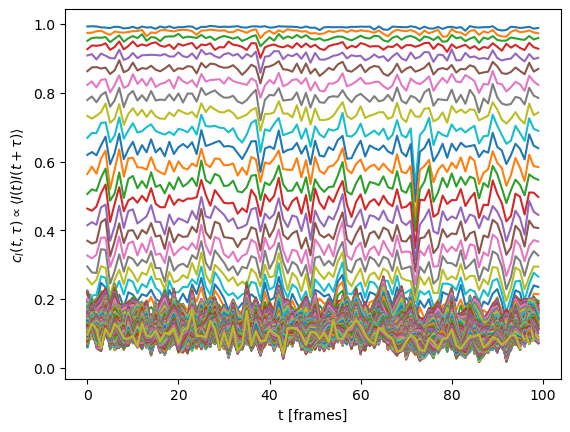

In [121]:
cI_data, times, lagidx_list = iof.ReadCIfile(os.path.join(fout, 'cI_ROI005_e00.dat'))
print('cI_data.shape = ' + str(cI_data.shape))
print('times         = ' + str(times))
print('lagidx_list   = ' + str(lagidx_list))
for i in range(1,len(lagidx_list)):
    plt.plot(times, cI_data[:,i], label='d'+str(lagidx_list[i]))
plt.xlabel('t [frames]')
plt.ylabel(r'$c_I(t, \tau)\propto \langle I(t)I(t+\tau) \rangle$')

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 16 g2-1 functions loaded from 16 ROIs found in folder D:\Data\Emanuele\251117\Dati\Scattering\AX1_0.003_SS\out_CAM0


16


Text(0, 0.5, '$g_2(\\tau)-1$')

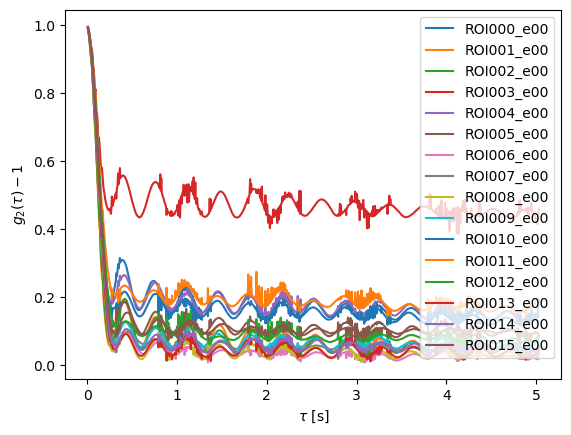

In [124]:
ROI_proc.AverageG2M1(fout, avg_interval=[30, 60], lag_tolerance=5e-3, lag_tolerance_isrelative=False)

g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(fout)
print(len(g2m1_data))
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()
plt.xlabel(r'$\tau$ [s]')
plt.ylabel(r'$g_2(\tau)-1$')

Text(0.5, 0, '$\\tau$ [s]')

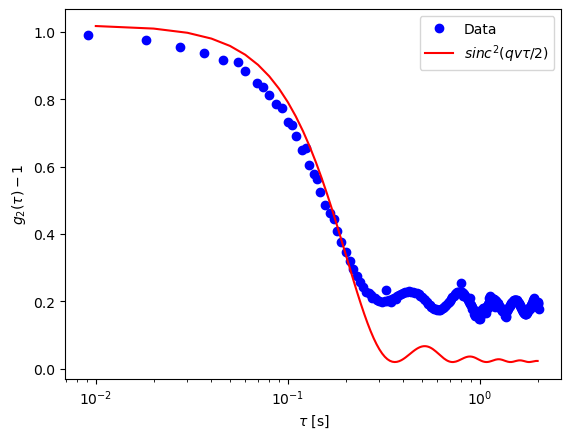

In [118]:
fps=100
test_tau_frames = np.linspace(1, 200, 200)
test_tau_s = test_tau_frames/fps
v_set = 3 #micron/s
expected_g2 = np.array([sincsq(v_set*t * q/2) for t in test_tau_s])

sel_g2m1 = [g2m1_data[i][0] for i in range(len(g2m1_data)) if i in sel]
avg_g2m1 = np.nanmean(sel_g2m1, axis=0)

fig, ax = plt.subplots()
ax.plot(lagtimes[0][0][1:], avg_g2m1[1:], 'bo', label='Data')
ax.plot(test_tau_s, expected_g2+0.02, 'r-', label=r'$sinc^2(qv\tau /2)$')
ax.set_xscale('log')
ax.legend()

ax.set_ylabel(r'$g_2(\tau)-1$')
ax.set_xlabel(r'$\tau$ [s]')

Text(0.5, 0, '$\\tau$ [s]')

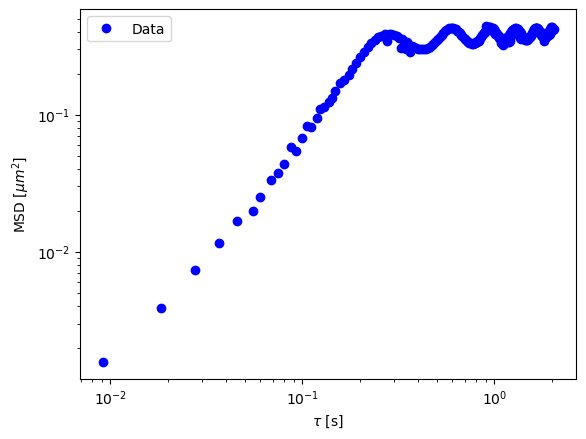

In [112]:
fig, ax = plt.subplots()
ax.plot(lagtimes[0][0][1:], -np.log(avg_g2m1[1:])*6/q**2, 'bo', label='Data')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

ax.set_ylabel(r'MSD $[\mu m^2]$')
ax.set_xlabel(r'$\tau$ [s]')

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 16 g2-1 functions loaded from 16 ROIs found in folder D:\Data\Emanuele\251117\Dati\Scattering\AX0_0.05\out_CAM0


16


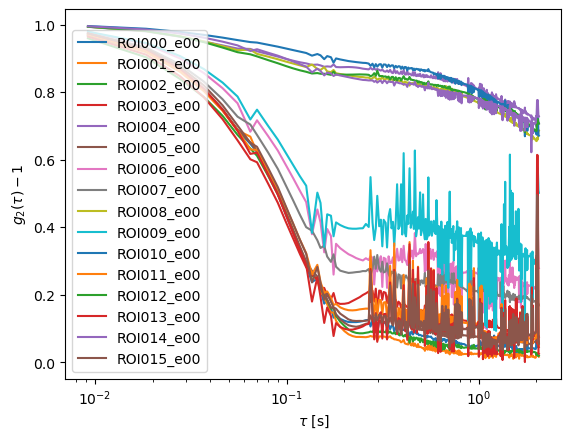

In [146]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(r'D:\Data\Emanuele\251117\Dati\Scattering\AX0_0.05\out_CAM0')
print(len(g2m1_data))
for i in range(len(g2m1_data)):
    plt.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
plt.legend()
plt.xlabel(r'$\tau$ [s]')
plt.ylabel(r'$g_2(\tau)-1$')
plt.xscale('log')

In [183]:
def calc_q(x, z, wavelength=0.532):
    theta = np.arctan2(x, z)    #rad
    wavelength = 0.532          #micron
    k = 2*np.pi/wavelength      #1/micron
    q = 2*k*np.sin(theta/2)     #1/micron
    return q

def read_folder(fpath, fps=100, min_delay=10, max_delay=5000):
    all_subf_list = [name for name in os.listdir(fpath) if os.path.isdir(os.path.join(fpath, name))]
    subf_list = []
    vel_list = []
    ax_list = []
    num_delays = []
    for f in all_subf_list:
        if f[-8:]=='_exclude':
            print('skipping folder {0}'.format(f))
        else:
            subf_list.append(f)
            if f=='Rest':
                ax_list.append(-1)
                vel_list.append(0)
            else:
                ax_list.append(int(f[2]))
                if f[-3:]=='_SS':
                    vel_list.append(float(f[4:-3]))
                elif f[-4:]=='_bis':
                    vel_list.append(float(f[4:-4]))
                else:
                    vel_list.append(float(f[4:]))
            if ax_list[-1]==1:
                max_tau = 20/(1e3*q*vel_list[-1])
                cur_delays = int(max_tau*fps)
                #print('  Probing affine motion. Maximum time delay: {0:.2f} s (= {1} images)'.format(max_tau, cur_delays))
            elif ax_list[-1]==0:
                max_tau = 0.02/(vel_list[-1])
                cur_delays = int(max_tau*fps)
                #print('  Probing nonaffine motion. Maximum time delay: {0:.2f} s (= {1} images)'.format(max_tau, cur_delays))
            else:
                max_tau = -1
                cur_delays = max_delay
                #print('  Probing rest dynamics. Analyzing all time delays ({0})'.format(cur_delays))
            num_delays.append(max(min_delay, min(cur_delays, max_delay)))
            print('Subfolder {0} : Speed = {1:.3f} mm/s; Axis = {2:2d}; Analyze {3:5d} time delays'.format(f.ljust(maxlen), vel_list[-1], ax_list[-1], num_delays[-1]))
    print('{0} subfolders found in parent folder {1}; {2} imposed speeds ranging between {3:.3f} and {4:.3f} mm/s'.format(len(subf_list), fpath, len(set(vel_list)), np.min(vel_list), np.max(vel_list)))
    return subf_list, vel_list, ax_list, num_delays

q = calc_q(x=6.5*2.5, z=30)
print('The scattering vector is q = {0:.2f} [1/um]'.format(q))

fparent = r'D:\Data\Emanuele\251117\Dati\Scattering'
subf_list, vel_list, ax_list, num_delays = read_folder(fparent)
maxlen = np.max([len(f) for f in subf_list])

The scattering vector is q = 5.80 [1/um]
skipping folder AX0_0.0003_SS_exclude
Subfolder AX0_0.001_SS : Speed = 0.001 mm/s; Axis =  0; Analyze  2000 time delays
Subfolder AX0_0.003_SS : Speed = 0.003 mm/s; Axis =  0; Analyze   666 time delays
Subfolder AX0_0.01_SS  : Speed = 0.010 mm/s; Axis =  0; Analyze   200 time delays
Subfolder AX0_0.02_SS  : Speed = 0.020 mm/s; Axis =  0; Analyze   100 time delays
Subfolder AX0_0.05     : Speed = 0.050 mm/s; Axis =  0; Analyze    40 time delays
Subfolder AX0_0.10     : Speed = 0.100 mm/s; Axis =  0; Analyze    20 time delays
Subfolder AX0_0.10_bis : Speed = 0.100 mm/s; Axis =  0; Analyze    20 time delays
Subfolder AX0_0.15     : Speed = 0.150 mm/s; Axis =  0; Analyze    13 time delays
Subfolder AX0_0.20     : Speed = 0.200 mm/s; Axis =  0; Analyze    10 time delays
Subfolder AX0_0.30     : Speed = 0.300 mm/s; Axis =  0; Analyze    10 time delays
Subfolder AX0_0.40     : Speed = 0.400 mm/s; Axis =  0; Analyze    10 time delays
Subfolder AX1_0.001

In [ ]:
ROI_gridshape = (4, 4)
img_tstep = 10

t0 = time.time()
for i in range(len(subf_list)):
    froot = os.path.join(fparent, subf_list[i])
    raw_flist = sf.FindFileNames(froot, Prefix='000_', Ext='.raw')
    print('\n***Analyzing folder {0} ({1} "000_*.raw" files found)'.format(froot, len(raw_flist)))
    for cur_fname in raw_flist:

        # LOAD MI FILE
        fname = cur_fname[:-4]
        MIinput = MI.MIfile(os.path.join(froot, fname+'.raw'), os.path.join(froot, fname+'_metadata.ini'))
        print('Raw file {0} has shape {1}'.format(fname, MIinput.Shape))

        # LOAD PIXEL MASK
        pxmask_fname = os.path.join(froot, 'px_mask'+cur_fname[-9:])
        pxmask = MI.ReadBinary(pxmask_fname, MIinput.ImageShape(), 'B')
        if pxmask_fname is None:
            print('No mask loaded (searched filename: {0})'.format(pxmask_fname))
        else:
            print('Mask file loaded from file {0}'.format(pxmask_fname))

        # GENERATE ROI TILING
        px_coords = sf.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
        ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, ROI_gridshape, common_mask=pxmask)

        # LOAD IMAGE TIMES
        imgtimes_fname = fname[:-5]+'_imgTimes.dat'
        im_times = RP.LoadImageTimes(imgtimes_fname, usecols=5, skiprows=1, root_folder=froot)
        print('{0} image times loaded from file {1}. Average fps: {2:.1f}'.format(im_times.shape[0], imgtimes_fname, 1/np.mean(np.diff(im_times.flatten()))))

        # LOAD ROIPROC CLASS
        ROI_proc = RP.ROIproc(MIinput, ROI_grid, imgTimes=im_times)

        fout = os.path.join(froot, fname+'_doDLS')
        cur_tstart = time.time()
        ROI_proc.LoopMaxInfoN = 5
        ROI_proc.dt_tolerance = 5e-3
        ROI_proc.dt_tolerance_isrelative = False
        ROI_proc.log_verbose = 1
        ROI_proc.doDLS(fout, lagtimes=list(range(num_delays[i])), reftimes='all', no_buffer=False, skip_avg_g2m1=True)
        cur_tend = time.time()

        print('\n>>>File {0} in folder {1}/{2} ({3}) successfully analyzed in {4:.1f} s. Elapsed time: {5:.1f} s\n'.format(cur_fname, i+1, len(subf_list), subf_list[i], cur_tend-cur_tstart, cur_tend-t0))

INFO:root:Set 16 valid ROIs
INFO:root:ROIproc.doDLS Analysis started! Input data is 10000 images (10000 times, 1 exposure times)
INFO:root:Analysis will resolve 16 ROIs and DLS will be performed on 1000 reference times and 2000 lagtimes. Output will be saved in folder D:\Data\Emanuele\251117\Dati\Scattering\AX0_0.001_SS\000_PCI_0p001_CAM0_doDLS
INFO:root:Now starting with SLS...



***Analyzing folder D:\Data\Emanuele\251117\Dati\Scattering\AX0_0.001_SS (2 "000_*.raw" files found)
Raw file 000_PCI_0p001_CAM0 has shape [10000, 400, 400]
Mask file loaded from file D:\Data\Emanuele\251117\Dati\Scattering\AX0_0.001_SS\px_mask_CAM0.raw
10000 image times loaded from file 000_PCI_0p001_imgTimes.dat. Average fps: 100.0


INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 1000 time points, 2000 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 10000, 1] (10000 images)
INFO:root:Computing cI with custom-defined set of reference time and/or lag times: result has shape (16, 1000, 2000) (16 ROIs, 1000 reference times, 2000 lag times)
INFO:root:Reference time 1/1000 (tref=0) completed
INFO:root:Reference time 201/1000 (tref=2000) completed
INFO:root:Reference time 401/1000 (tref=4000) completed
INFO:root:Reference time 601/1000 (tref=6000) completed
INFO:root:Reference time 801/1000 (tref=8000) completed
INFO:root:Reference time 1000/1000 (tref=9990) completed
INFO:root:Now saving ROI 0 to file
INFO:root:Now saving ROI 1 to file
INFO:root:Now saving ROI 2 to file
INFO:root:Now saving ROI 3 to file
INFO:root:Now saving ROI 4 to file
INFO:root:Now saving ROI 5 to file
INFO:root:Now saving ROI 6 to file
INFO:root:Now saving ROI 7 to file
INFO:root:Now saving ROI


>>>File 000_PCI_0p001_CAM0.raw in folder 1/17 (AX0_0.001_SS) successfully analyzed in 4019.8 s. Elapsed time: 4019.9 s

Raw file 000_PCI_0p001_CAM1 has shape [10000, 400, 400]
Mask file loaded from file D:\Data\Emanuele\251117\Dati\Scattering\AX0_0.001_SS\px_mask_CAM1.raw
10000 image times loaded from file 000_PCI_0p001_imgTimes.dat. Average fps: 100.0
Created folder: D:\Data\Emanuele\251117\Dati\Scattering\AX0_0.001_SS\000_PCI_0p001_CAM1_doDLS


INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 1000 time points, 2000 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 10000, 1] (10000 images)
INFO:root:Computing cI with custom-defined set of reference time and/or lag times: result has shape (16, 1000, 2000) (16 ROIs, 1000 reference times, 2000 lag times)
INFO:root:Reference time 1/1000 (tref=0) completed
INFO:root:Reference time 201/1000 (tref=2000) completed
INFO:root:Reference time 401/1000 (tref=4000) completed
INFO:root:Reference time 601/1000 (tref=6000) completed
INFO:root:Reference time 801/1000 (tref=8000) completed
INFO:root:Reference time 1000/1000 (tref=9990) completed
INFO:root:Now saving ROI 0 to file
INFO:root:Now saving ROI 1 to file
INFO:root:Now saving ROI 2 to file
INFO:root:Now saving ROI 3 to file
INFO:root:Now saving ROI 4 to file
INFO:root:Now saving ROI 5 to file
INFO:root:Now saving ROI 6 to file
INFO:root:Now saving ROI 7 to file
INFO:root:Now saving ROI